# Comparing Supervised Learning and RL Using Stock Data

(Insert explanation of our process here)

## Supervised Learning Approach

In [140]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras import optimizers
from keras.callbacks import CSVLogger
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook
import os

TIME_STEPS = 50
BATCH_SIZE = 50


### Reading Stock Data

In [121]:
msft = pd.read_csv("./Individual_Stock_Data/MSFT.csv")

In [122]:
msft.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,30.62,31.10,30.59,30.95,24.53,38409100
1,2010-01-05,30.85,31.10,30.64,30.96,24.53,49749600
2,2010-01-06,30.88,31.08,30.52,30.77,24.38,58182400
3,2010-01-07,30.63,30.70,30.19,30.45,24.13,50559700
4,2010-01-08,30.28,30.88,30.24,30.66,24.30,51197400


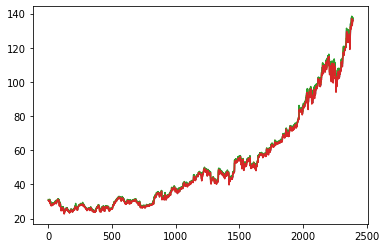

In [123]:
plt.figure()
plt.plot(msft["Open"])
plt.plot(msft["Close"])
plt.plot(msft["High"])
plt.plot(msft["Low"])
plt.show()

### Normalize Data

In [124]:
df_train, df_test = train_test_split(msft, train_size=0.8, test_size=0.2, shuffle=False)

In [125]:
df_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,30.62,31.10,30.59,30.95,24.53,38409100
1,2010-01-05,30.85,31.10,30.64,30.96,24.53,49749600
2,2010-01-06,30.88,31.08,30.52,30.77,24.38,58182400
3,2010-01-07,30.63,30.70,30.19,30.45,24.13,50559700
4,2010-01-08,30.28,30.88,30.24,30.66,24.30,51197400


In [126]:
df_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
1913,2017-08-09,72.25,72.51,72.05,72.47,69.95,22213400
1914,2017-08-10,71.90,72.19,71.35,71.41,68.92,24734500
1915,2017-08-11,71.61,72.70,71.28,72.50,69.98,21443700
1916,2017-08-14,73.06,73.72,72.95,73.59,71.03,20096600
1917,2017-08-15,73.59,73.59,73.04,73.22,71.05,19181400


In [127]:
train_cols = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
print("Train and Test Size:", len(df_train), len(df_test))
x = df_train.drop(columns=["Date"]).values
min_max_scaler = MinMaxScaler()

# Transforming Data
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.fit_transform(df_test.drop(columns=["Date"]).values)

Train and Test Size: 1913 479


In [128]:
x_train.shape, x_test.shape

((1913, 6), (479, 6))

## Build Time-Series Structure

In [129]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0, dim_1 = mat.shape[0] - TIME_STEPS, mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    for i in range(dim_0):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat
    
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

length of time-series i/o (1863, 50, 6) (1863,)
length of time-series i/o (429, 50, 6) (429,)


In [130]:
lstm_model = Sequential()
lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, recurrent_dropout=0.0, stateful=True,     kernel_initializer='random_uniform'))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))
optimizer = optimizers.RMSprop(lr=0.001)
lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)

In [148]:
csv_logger = CSVLogger("stock_supervised.log", append=True)

history = lstm_model.fit(x_t, y_t, epochs=50, verbose=2, batch_size=BATCH_SIZE,
                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])
print(history)


Train on 1850 samples, validate on 200 samples
Epoch 1/50
 - 1s - loss: 7.6360e-04 - val_loss: 5.9342e-04
Epoch 2/50
 - 1s - loss: 6.8462e-04 - val_loss: 6.5965e-04
Epoch 3/50
 - 1s - loss: 7.1230e-04 - val_loss: 6.0293e-04
Epoch 4/50
 - 1s - loss: 6.5997e-04 - val_loss: 6.7046e-04
Epoch 5/50
 - 1s - loss: 7.4928e-04 - val_loss: 6.4454e-04
Epoch 6/50
 - 1s - loss: 6.5394e-04 - val_loss: 6.7548e-04
Epoch 7/50
 - 1s - loss: 6.6686e-04 - val_loss: 7.4150e-04
Epoch 8/50
 - 1s - loss: 6.7310e-04 - val_loss: 6.7661e-04
Epoch 9/50
 - 1s - loss: 7.5245e-04 - val_loss: 5.7973e-04
Epoch 10/50
 - 1s - loss: 6.9020e-04 - val_loss: 6.4021e-04
Epoch 11/50
 - 1s - loss: 6.9323e-04 - val_loss: 5.6561e-04
Epoch 12/50
 - 1s - loss: 5.6076e-04 - val_loss: 5.5067e-04
Epoch 13/50
 - 1s - loss: 6.7880e-04 - val_loss: 6.2868e-04
Epoch 14/50
 - 1s - loss: 6.9547e-04 - val_loss: 8.3145e-04
Epoch 15/50
 - 1s - loss: 6.5539e-04 - val_loss: 5.5963e-04
Epoch 16/50
 - 1s - loss: 6.9550e-04 - val_loss: 5.3506e-04
Ep

In [149]:
y_pred = lstm_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]

Error is 0.000829401360537384 (200,) (200,)
[0.5580264  0.5635338  0.5709462  0.57666075 0.57053506 0.5641875
 0.5690545  0.5579638  0.5552088  0.5492847  0.5437789  0.5342965
 0.5370583  0.5494031  0.56105065]
[0.5645623  0.5737532  0.57646527 0.56637035 0.55446738 0.5748079
 0.5461805  0.54587916 0.54497514 0.53427754 0.52086786 0.53714027
 0.5446738  0.55733012 0.57541058]


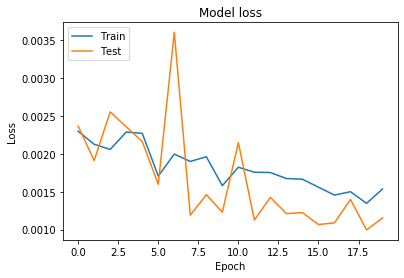

In [144]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig( 'train_vis_BS_.png')